# Projet Python pour le Data Scientist 

Projet réalisé par Eric Vong, Thibaut Valour et Solène Blasco Lopez

Ce projet Python utilise les données de l'OpenData de Paris sur l'encadrement des loyers de 2019, enrichies par l'intermédiaire de données web-scrapées sur internet. Il expérimente différents modèles de régression entrainés sur ces données, dans le but de révéler les déterminants des loyers de référence des appartements parisiens, et d'être capable de les prédire. 

L'objet de ce projet est donc de répondre à la problématique suivante : 
**Quels sont les déterminants du loyer d'un bien immobilier parisien ?**

Une première partie de ce projet est consacrée à la récupération des données, et à la création de nouvelles variables explicatives, à partir de la base initiale ou de webscraping. Dans un second temps, nous avons mené une analyse descriptive pour représenter les données et se faire une première idée de la manière dont les variables à notre disposition impactent les loyers parisiens. Enfin, nous avons implémenter des modèles de régressions pour tenter de prédire les loyers parisiens à partir des variables explicatives les plus pertinentes.

*Import des modules nécessaires à la réalisation du projet :*

In [2]:
import re

# Manipulation des donneés :
import pandas as pd
import geopandas as gpd

# Web-scraping :
import urllib
import bs4 

#Traitement des données :
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, lasso_path

# Représentations graphiques :
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Partie 1 - Création de la base de données
*(Les lignes de code qui suivent peuvent être trouvées dans le dossier `data` du dépôt git)*

### 1. Récupération des données de la mairie de Paris concernant l'encadrement des loyers

La mairie de Paris a mis en ligne une base de données concernant l'encadrement des loyers de ses logements en 2019. On y trouve une classification des logements, selon leur localisation (quartier administratif) et leur type (nombre de pièces, époque de construction, location meublée/non-meublée), accompagnée de leurs loyers de référence. 

*Lien contenant les informations de la mairie de Paris sur ces données : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt&sort=-id_zone&location=15,48.84958,2.34691&basemap=jawg.streets*

*Import des données :*

In [3]:
donnees_brutes = gpd.read_file('https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

On ne sélectionne que les colonnes qui nous intérèssent : 
- `nom_quartier` et `id_quartier` : nom et id du quartier (administratif)
- `ref` : loyer de référence (encadrement : `min` et `max`)
- `epoque` : époque de construction de l'appartement
- `meuble_txt` : location en tant que logement meublé ou non-meublé
- `piece` : nombre de pièces
- `geometry` : représentation graphique du quartier.

In [4]:
donnees = donnees_brutes[['nom_quartier','id_quartier','ref','min','max','epoque','meuble_txt','piece','geometry']]

In [5]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry
0,Saint-Fargeau,78,23.1,16.17,27.72,Avant 1946,meublé,3,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."
1,Villette,73,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ..."
2,Belleville,77,21.6,15.12,25.92,1946-1970,non meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
3,Pont-de-Flandre,74,18.9,13.23,22.68,1971-1990,meublé,3,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ..."
4,Charonne,80,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.41602 48.84675, 2.41599 48.84661, ..."


Cette base de données référence 2560 appartements. On vérifie qu'il n'y a pas de valeurs manquantes :

In [6]:
donnees.count()

nom_quartier    2560
id_quartier     2560
ref             2560
min             2560
max             2560
epoque          2560
meuble_txt      2560
piece           2560
geometry        2560
dtype: int64

### 2. Création de deux variables : superficie des quartiers et leur distance au centre de Paris


Pour tenter de mieux comprendre l'impact que pourrait avoir le quartier de localisation sur le loyer de référence d'un appartement, on utilise la variable `geometry`, qui représente les quartiers, pour créer deux nouvelles variables :
- une variable `superficie_quartier`, qui correspond à la superficie de chaque quartier. L'intuition derrière ce choix de variable est de représenter en partie l'"offre" d'appartements de chaque quartier. En effet, plus un quartier est petit (notamment dans le centre de Paris), plus les appartements mis à la location sont "rares" et donc prisés et chers.
- une variable `distance_centre`, qui correspond à la distance du centre de chaque quartier au centre de Paris. L'intuition derrière ce choix de variable est de représenter en partie la "demande" d'appartements. En effet, plus un quartier est proche du centre de Paris, plus les appartements mis à la location sont attractifs, et donc chers, car mieux situés.

*Remarque : Les données de la mairie de Paris utilisent le système de projection `epsg 4326`. Pour la création de ces variables, nous allons donc devoir passer par le système de projection `epsg 2154` pour pouvoir obtenir des distances en mètres et des aires en mètres carrés.*

In [7]:
donnees.crs

{'init': 'epsg:4326'}

- Ajout de la variable `distance_centre_paris` :

In [8]:
#Récupération des centres des quartiers :

df = donnees.centroid 
df = df.to_crs(epsg=2154)

In [9]:
#Centre de Paris (coordonnées trouvées sur internet): 

longitude = [2.3488 for i in range(2560)]
latitude = [48.8534 for i in range(2560)]

df2 = gpd.GeoDataFrame(geometry = gpd.points_from_xy(longitude, latitude),crs={'init': 'epsg:4326'})
df2 = df2.to_crs(epsg=2154)

In [10]:
# Tables des distances pour chaque appartement de la base de données :

distances = pd.DataFrame(df.distance(df2)*10**(-3),columns=["distance_centre_paris"])  #la multiplication par 10^3 convertit les mètres en kms

In [11]:
# Ajout de la nouvelle variable à la base de données : 

donnees = donnees.join(distances)

In [12]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris
0,Saint-Fargeau,78,23.1,16.17,27.72,Avant 1946,meublé,3,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464
1,Villette,73,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...",4.249599
2,Belleville,77,21.6,15.12,25.92,1946-1970,non meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188
3,Pont-de-Flandre,74,18.9,13.23,22.68,1971-1990,meublé,3,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327
4,Charonne,80,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.41602 48.84675, 2.41599 48.84661, ...",4.304793


- Ajout de la variable `superficie_quartier` :

In [13]:
# On ne conserve que les géométries, pour les passer dans le système espg 2154 :
df3 = donnees.geometry
df3 = df3.to_crs(epsg=2154)

In [14]:
#Création de la nouvelle variable :
donnees['superficie_quartier'] = df3.area.div(10**6)  #La division convertit les m² en km²

In [15]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier
0,Saint-Fargeau,78,23.1,16.17,27.72,Avant 1946,meublé,3,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464,1.486971
1,Villette,73,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...",4.249599,1.285705
2,Belleville,77,21.6,15.12,25.92,1946-1970,non meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569
3,Pont-de-Flandre,74,18.9,13.23,22.68,1971-1990,meublé,3,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327,2.376238
4,Charonne,80,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.41602 48.84675, 2.41599 48.84661, ...",4.304793,2.090904


### 3. Enrichissement des données : création d'un score lié aux stations de métro et de rer des quartiers

Pour enrichir ces données et mieux comprendre l'effet du quartier sur le loyer d'un logement d'un point de vue "demande"/attractivité, nous avons essayé de créer un score `score_metro` pour chaque quartier lié aux lignes de métro et de rer. Il est calculé de la manière suivante : 
   - on liste les stations de métro/rer, et leurs lignes associées, qui appartiennent à chaque quartier
   - on en déduit une liste des lignes distinctes de métro et de rer qui passent dans chaque quartier
   - on attribue un score à chaque ligne, qui correspond à sa fréquentation annuelle 
   - on somme pour chaque quartier les scores de ses lignes de métro/rer
   - le score de chaque quartier, qui correspond à cette somme, est enfin divisé par le plus grand score obtenu parmi les quartiers, pour être finalement compris entre 0 et 1.    

Pour la première étape, on récupère la liste des stations de métro et de rer de Paris, ainsi que leurs positions géographiques et leurs lignes desservies. Ces données sont récupérées sur Wikipédia par web-scraping. Pour chaque station, on récupère son nom et on se rend sur sa page Wikipédia pour récupérer ses coordonnées géographiques. Cette station est dupliquée pour chaque ligne de métro qu'elle dessert. 

*Les liens utilisés sont les suivants :*
- *Pour le métro : https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris*
- *Pour le rer : https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France*

In [16]:
# Fonction pour transformer les coordonnées récoltées (sous format DMS nord-est) en format DD :

dd = lambda d,m,s : float(d) + float(m)/60 + float(s)/(60*60)
def dms_to_dd (dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dd(parts[0], parts[1], parts[2])
    lng = dd(parts[4], parts[5], parts[6])
    return (lat, lng)

In [17]:
#Création de la base de données des stations de métro et de rer par web scraping : 

nom = []
ligne = [] 
latitude = []
longitude = []

urls = ['https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris','https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France']

for url in urls : 

    sock = urllib.request.urlopen(url).read() 
    page=bs4.BeautifulSoup(sock)

    liste_stations = page.find('table').findAll('tr')
    
    for station in liste_stations[1:] :
    
        #Nom de la station :    
        nom_station = station.find('a').text
    
        #Coordonnées géographiques de la station :
        url_station = "http://fr.wikipedia.org"+station.find('a').get('href')
    
        search = urllib.request.urlopen(url_station).read()
        search_station=bs4.BeautifulSoup(search)
    
        coord = search_station.find('a',{'class': "mw-kartographer-maplink"}).text
        lat,lng = dms_to_dd(coord)
    
        #Lignes desservies par la station :    
        lignes = station.find('span',{'style' : "white-space:nowrap"}).findAll('span')
    
        for l in lignes : 
            nom.append(nom_station)
            ligne.append(l.get('data-sort-value'))
            latitude.append(lat)
            longitude.append(lng)
            
stations = gpd.GeoDataFrame(pd.DataFrame({'nom' : nom, 'ligne' : ligne}),geometry=gpd.points_from_xy(longitude, latitude))

In [18]:
stations.head(5)

,nom,ligne,geometry
0,Abbesses,12 !,POINT (2.33861 48.88444)
1,Alésia,04 !,POINT (2.32667 48.82833)
2,Alexandre Dumas,02 !,POINT (2.39500 48.85611)
3,Alma - Marceau,09 !,POINT (2.30028 48.86500)
4,Anatole France,03 !,POINT (2.28556 48.89194)


On récupère ensuite une base de données de la mairie de Paris contenant la liste de ses quartiers administratifs et leur représentation graphique :

In [19]:
quartiers_bruts = gpd.read_file('https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
quartiers = quartiers_bruts[['l_qu','c_qu','geometry']]  #l_qu : nom du quartier ; c_qu : numéro du quartier

In [20]:
quartiers.head(5)

,l_qu,c_qu,geometry
0,Rochechouart,36,"POLYGON ((2.34971 48.88222, 2.34983 48.88109, ..."
1,Bercy,47,"POLYGON ((2.39114 48.82611, 2.39026 48.82573, ..."
2,Halles,2,"POLYGON ((2.34937 48.86058, 2.34822 48.85852, ..."
3,Saint-Gervais,14,"POLYGON ((2.36376 48.85568, 2.36294 48.85456, ..."
4,Saint-Thomas-d'Aquin,25,"POLYGON ((2.32213 48.84925, 2.32054 48.84842, ..."


On associe ensuite à chaque station le quartier auquel elle appartient :

In [21]:
stations_quartiers = gpd.sjoin(stations, quartiers, op='intersects')

C:\Users\blasc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


Il ne reste plus qu'à supprimer les doublons pour savoir quelles lignes de métro ou rer passent dans chaque quartier de Paris. 

In [22]:
lignes_quartiers = stations_quartiers[['c_qu','ligne']].drop_duplicates()

In [23]:
lignes_quartiers.tail(5)

,c_qu,ligne
346,11,08 !
349,7,03 !
361,15,07 !
369,4,01 !
453,19,B !


Ensuite, on réalise un nouveau web scraping sur Wikipédia pour attribuer un score à chaque ligne : on va lister chaque ligne et sa fréquentation annuelle.

In [24]:
#Pour le rer, il faut aller sur chaque page Wikipédia de la ligne. Pour aller plus vite, on le fait manuellement (il n'y a que 5 lignes) :

lignes = ['A !','B !','C !','D !','E !']
frequentation = [309.36,165.5,140,145,60] 


#Pour le métro, il existe directement un classement sur Wikipédia :

sock = urllib.request.urlopen("https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation").read() 
page=bs4.BeautifulSoup(sock)

liste_lignes = page.find('table').findAll('tr')

for ligne in liste_lignes[1:] :
    
    freq = ligne.find('bdi')
    
    for sous_ligne in ligne.findAll('span') :
        lignes.append(sous_ligne.get('data-sort-value'))
        frequentation.append(float(freq.text.replace(',','.')))
        
lignes_freq = pd.DataFrame({'ligne' : lignes,'fréquentation' : frequentation})

In [25]:
lignes_freq.head(5)

,ligne,fréquentation
0,A !,309.36
1,B !,165.50
2,C !,140.00
3,D !,145.00
4,E !,60.00


Enfin, on attribue à chaque quartier son score, qui est la somme des scores de ses lignes, le tout divisé par le plus grand score obtenu par un quartier.

In [26]:
# Ajout du score des lignes pour chaque quartier : 

lignes_quartiers_freq = lignes_quartiers.merge(lignes_freq, on='ligne')

In [27]:
#Création du score des quartiers : 

quartiers_freq = lignes_quartiers_freq[['c_qu','fréquentation']].groupby('c_qu').sum()

m = max(quartiers_freq['fréquentation'])

quartiers_freq['fréquentation'] = quartiers_freq['fréquentation']/m

Ajout du score obtenu à notre base de données :

In [28]:
donnees_augmentees = donnees.join(quartiers_freq, on='id_quartier')
donnees_augmentees.rename(columns={'fréquentation': 'score_metro'}, inplace=True)

In [29]:
donnees_augmentees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,distance_centre_paris,superficie_quartier,score_metro
0,Saint-Fargeau,78,23.1,16.17,27.72,Avant 1946,meublé,3,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",4.643464,1.486971,0.186527
1,Villette,73,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...",4.249599,1.285705,0.468929
2,Belleville,77,21.6,15.12,25.92,1946-1970,non meublé,4,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",3.485188,0.806569,0.038651
3,Pont-de-Flandre,74,18.9,13.23,22.68,1971-1990,meublé,3,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",5.379327,2.376238,0.298062
4,Charonne,80,14.6,10.22,17.52,1946-1970,non meublé,4,"POLYGON ((2.41602 48.84675, 2.41599 48.84661, ...",4.304793,2.090904,0.239635


### Eventuelles limites de ce score : 

On a ici créer par nous mêmes un score pour chaque quartier, d'autant plus élévé que les lignes de métro et rer qui passent dans un quartier sont nombreuses et importantes en terme de fréquentation.

Cependant, il convient de noter les éventuelles limites de ce score : 
- on ne prend pas en compte les stations de vélib et les autres types de transports

- les quartiers ont des tailles très diverses : les grands quartiers aux extrémités ouest (Auteuil (61), Muette (62), Porte-Dauphine (63)) et est (Pictus (46) et Bel-Air (45)) de Paris ne sont donc pas forcément très bien représentés en termes de transports via seulement le métro et le rer. On constate sur le graphique suivant qu'une majorité de la superficie de ces quartiers n'est pas désservie par le métro ou le rer.

- on ne regarde ici que les lignes qui passent dans un quartier. Mais :
    - pour les petits quartiers du centre de Paris par exemple, il est très facile d'accéder sans trop de temps aux stations des quartiers voisins. On note sur le graphique suivant que beaucoup de stations de métro sont situées sur les frontières des quartiers. Une éventuelle solution urait pu être d'essayer de prendre en compte pour chaque quartier le score des quartiers voisins, avec une pondération adaptée (liée à la superficie par exemple).
    - pour les plus grand quartiers, si l'on habite proche des frontières on peut par exemple préférer les stations du quartier d'à côté, plus proches, que les stations à l'autre bout de son propre quartier. Pour faire un score plus fin, il aurait donc fallu que l'on ait par exemple une base de données avec des annonces réelles et des positions précises d'appartements. 

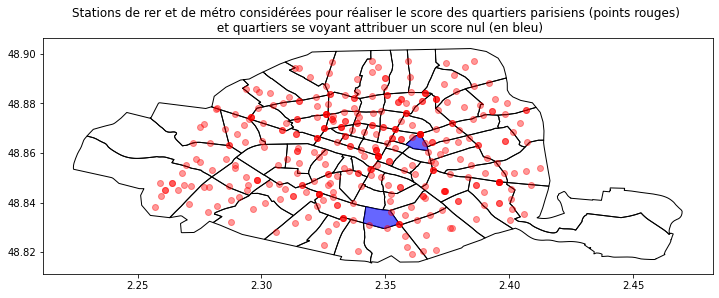

In [40]:
axi = stations_quartiers.plot(figsize = (12,15), color = 'red', alpha = 0.4, zorder=2)
quartiers.plot(ax = axi, zorder=1, edgecolor = "black", facecolor="none",color = None)
quartiers[quartiers['c_qu'].isin([10,52])].plot(ax=axi,alpha = 0.6,color='blue')

plt.title("Stations de rer et de métro considérées pour réaliser le score des quartiers parisiens (points rouges) \n et quartiers se voyant attribuer un score nul (en bleu)")
plt.show()

* De plus, on remarque que deux quartiers (représentés en bleu sur le graphique ci-dessus) se voient attribués un score nul :

In [41]:
donnees_augmentees[['nom_quartier','id_quartier','score_metro']][donnees_augmentees.isnull().any(axis=1)].drop_duplicates()

,nom_quartier,id_quartier,score_metro
22,Enfants-Rouges,10,NaN
89,Croulebarbe,52,NaN


Cela semble être du au fait que certaines stations de métro et de rer sont situées sur les limites ou proches de ces quartiers. Comme elles ne sont prises en compte que pour un seul quartier, les quartiers Enfants-Rouges (10) et Croulebarbe (52) se sont retrouvés sans score...

On remarque sur le graphique qu'il serait incohérent de remplacer les valeurs manquantes par des $0$, car ces deux quartiers sont plutôt bien situés dans Paris, et à proximité de stations de métro et de rer. Nous avons donc fait le choix de remplacer les valeurs manquantes par la moyenne des scores obtenus par les quartiers parisiens (`0.3357002566419284`). Ce choix est du au fait que visuellement, les quartiers aux valeurs manquantes ont l'air d'avoir un niveau "intermédiaire" : ils ne sont pas dans le centre de Paris très desservi, mais pas non plus parmi les quartiers extérieurs les moins fréquentés.

In [48]:
score_moy = donnees_augmentees['score_metro'].mean()
donnees_augmentees['score_metro'][donnees_augmentees['score_metro'].isnull()] = score_moy

<ipython-input-48-7dff315c7377>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donnees_augmentees['score_metro'][donnees_augmentees['score_metro'].isnull()] = score_moy


## Partie intermédiaire - Preprocessing des données

*(Les fonctions de cette partie, ainsi que la nouvelle base créée, sont disponibles dans le dossier `preprocessing` du dépôt git)*

### 1. Création d'une base de variables numériques 

Avant de passer à l'analyse descriptive et à la modélisation, et pour faciliter ces étapes, on commence par mettre en forme les données. 

On va créer une nouvelle base de données `donnees_num.geojson`dans laquelle toutes les variables sont sous forme numérique. 

In [58]:
donnees_num = donnees_augmentees.copy()

- Variable `meuble_txt` :
on la transforme en une variable binaire `meuble_bin` telle que :

    - `meuble_bin` = 1 si l'appartement est meublé
    - `meuble_bin` = 0 si l'appartement est non-meublé

Comme on n'a que deux modalités, on peut utiliser `LabelEncoder`.

In [59]:
donnees_num['meuble_bin'] = 1 - LabelEncoder().fit_transform(donnees_num['meuble_txt'])

#Suppression de 'meuble_txt' :
donnees_num.drop('meuble_txt',axis=1,inplace=True)

- Variable `id_quartier` : 
il y a 80 modalités, donc on crée 80 nouvelles variables `q_i` pour $1\leq i \leq80$ telles que : 
    - `q_i` = 1 si `id_quartier` $=$ i
    - `q_i` = 0 si `id_quartier` `$\neq$ i

Comme on a 80 modalités, on utilise cette fois `OneHotEncoder`.

In [60]:
donnees_num = donnees_num.sort_values('id_quartier').reset_index()
ohe_id_quartier = pd.DataFrame(LabelBinarizer().fit_transform(donnees_num['id_quartier']))

# On renomme les colonnes sous la forme : q_[1-80]
colonnes = {}
for i in range(80) :
    colonnes[i] = 'q_'+str(i+1)
ohe_id_quartier.rename(columns=colonnes, inplace=True)

# Ajout des nouvelles variables et suppression de 'nom_quartier' et 'id_quartier' :
donnees_num = donnees_num.join(ohe_id_quartier)
donnees_num.drop(['nom_quartier','id_quartier','index'],axis=1,inplace=True)

- Variable `epoque` : 
il y a 4 modalités, donc on crée 4 nouvelles variables `epoque_i` pour $0 \leq i\leq 3$ telles que : 
    - `epoque_0` = 1 si `epoque` = 'Avant 1946', et 0 sinon
    - `epoque_1` = 1 si `epoque` =  '1946-1970', et 0 sinon
    - `epoque_2` = 1 si `epoque` = '1971-1990', et 0 sinon
    - `epoque_3` = 1 si `epoque` =  'Apres 1990', et 0 sinon

On utilise encore une fois `OneHotEncoder`.

In [61]:
ohe_epoque = pd.DataFrame(LabelBinarizer().fit_transform(donnees_num['epoque']))

# On renomme les colonnes sous la forme : epoque_[0-79]

#donnees[['epoque']].head(10) #pour savoir comment renommer chaque colonne
colonnes = {0 : 'epoque_1', 1 : 'epoque_2', 2 : 'epoque_3', 3 : 'epoque_0'}  
ohe_epoque.rename(columns=colonnes, inplace=True)

# Ajout des nouvelles variables et suppression de 'epoque' :
donnees_num = donnees_num.join(ohe_epoque)
donnees_num.drop(['epoque'],axis=1,inplace=True)

- Variable `piece` : même si cette variable peut être vue comme une variable catégorielle, nous avons choisi de la laisser telle quelle et de la considérer comme une variable numérique, car elle induit une relation d'ordre entre les appartements qui n'est pas incohérente et que nous souhaitons préserver.

Aperçu de la nouvelle base ainsi créée :

In [62]:
donnees_num.head(2)

,ref,min,max,piece,geometry,distance_centre_paris,superficie_quartier,score_metro,meuble_bin,q_1,...,q_75,q_76,q_77,q_78,q_79,q_80,epoque_1,epoque_2,epoque_3,epoque_0
0,32.7,22.89,39.24,1,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...",1.299442,0.869001,0.603253,0,1,...,0,0,0,0,0,0,0,0,0,1
1,28.6,20.02,34.32,2,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ...",1.299442,0.869001,0.603253,1,1,...,0,0,0,0,0,0,0,1,0,0


### 2. Création de fonctions de preprocessing utilisables par la suite

On crée ici une fonction permettant de standardiser une base de données numériques passée en argument. Nous en aurons notamment besoin par la suite lorsque nous ferons un modèle Lasso pour sélectionner les variables d'intérêt de notre base de données.

In [63]:
def standardisation(df) :
    """
    Fonction qui renvoie une version standardisée d'une base de données passée en arguments. 
    
    ! La standardisation est appliquée sur toutes les colonnes : df ne doit contenir que des variables numériques !
    """
    
    data = StandardScaler().fit(df).transform(df.fillna(0))
    
    return data

## Partie 2 - Analyse descriptives et sélection des variables d'intérêt

*(Les fonctions de cette partie sont disponibles dans les dossiers `visualization` (et `modelisation` pour le modèle Lasso) du dépôt git)*

### 1. Analyse descriptives

In [43]:
analyse = donnees_augmentees.groupby(['nom_quartier','meuble_txt','epoque']).mean()
todrop=['id_quartier','min','max']
analyse.drop(todrop,axis=1,inplace=True)
analyse.head(16)

ref  piece  distance_centre_paris  \
nom_quartier meuble_txt epoque                                             
Amérique     meublé     1946-1970   20.650    2.5               4.643892   
                        1971-1990   20.025    2.5               4.643892   
                        Apres 1990  22.150    2.5               4.643892   
                        Avant 1946  25.050    2.5               4.643892   
             non meublé 1946-1970   18.275    2.5               4.643892   
                        1971-1990   17.700    2.5               4.643892   
                        Apres 1990  19.625    2.5               4.643892   
                        Avant 1946  22.150    2.5               4.643892   
Archives     meublé     1946-1970   27.450    2.5               1.237744   
                        1971-1990   28.250    2.5               1.237744   
                        Apres 1990  28.725    2.5               1.237744   
                        Avant 1946  30.775    2.5               1.237744   
             non meublé 1946-1970   24.275    2.5               1.237744   
                        1971-1990   25.000    2.5               1.237744   
                        Apres 1990  25.425    2.5               1.237744   
                        Avant 1946  27.225    2.5               1.237744   

                                    superficie_quartier  score_metro  
nom_quartier meuble_txt epoque                                        
Amérique     meublé     1946-1970              1.835720     0.369742  
                        1971-1990              1.835720     0.369742  
                        Apres 1990             1.835720     0.369742  
                        Avant 1946             1.835720     0.369742  
             non meublé 1946-1970              1.835720     0.369742  
                        1971-1990              1.835720     0.369742  
                        Apres 1990             1.835720     0.369742  
                        Avant 1946             1.835720     0.369742  
Archives     meublé     1946-1970              0.367728     0.101295  
                        1971-1990              0.367728     0.101295  
                        Apres 1990             0.367728     0.101295  
                        Avant 1946             0.367728     0.101295  
             non meublé 1946-1970              0.367728     0.101295  
                        1971-1990              0.367728     0.101295  
                        Apres 1990             0.367728     0.101295  
                        Avant 1946             0.367728     0.101295

De façon attendue, lorsqu'on prend un bien immobilier situé dans le même quartier et datant de la même époque, le bien qui sera meublé coûtera plus cher que le bien non meublé. 

On peut remarquer que les appartements historiques (avant 1946) sont les plus chers suivi par les appartements très modernes (post 1990), cela peut s'expliquer par des raisons historiques : les appartements entre 1946 et 1990 ont été construits pendant la période (et peu après) des 30 glorieuses, il fallait loger beaucoup de monde rapidement, ils sont donc moins travaillés esthétiquements que ceux avant et après cette période. 


In [66]:
donnees_acp = donnees_num.copy()
todrop = ['q_'+str(i+1) for i in range(80)]+['geometry','min','max']
donnees_acp.drop(todrop,axis=1,inplace=True)

On regénère les données utilisées et on les numérise afin de pouvoir effectuer une ACP sur les données. On ne prendra pas en compte les quartiers puisqu'ils vont avoir une contribution non nulle à chaque composante la rendant inutilisable. De plus, on peut justifier ce choix par le fait que les quartiers sont identifiables par le score du métro, la superficie et la distance au centre de Paris.

In [67]:
donnees_acp = donnees_acp.fillna(0)
features = [donnees_acp.columns[i] for i in range(len(donnees_acp.columns))]
x = donnees_acp.loc[:,features].values
x = StandardScaler().fit_transform(x)

Certains quartiers n'ont pas de score de métro, nous leur assignons donc 0 même si cela est discutable comme vu précédemment, nous prenons toutes les variables dans nos données et nous les normalisons pour pouvoir effectuer une ACP.

In [ ]:
n_components = len(donnee_acp.columns)
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component' + str(i+1) for i in range(len(donnees_acp.columns))])

On effectue l'ACP, on garde le même nombre de composantes principales que de variables, cela nous permettra d'avoir une variance explicative égale à 1, nous choissirons ensuite les variables les plus appropriées.

In [ ]:
pca.explained_variance_ratio_

On voit que les 2 dernières variables de l'ACP expliquent peu (contribution de 2.5%), on peut prendre 6 composantes principales (même si cela est à discuter, la règle du coude étant inutilisable ici, on en prend 6 plutôt que 7 car la 7ème a une contribution inférieure à 1/9)

In [ ]:
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()


In [ ]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0,pca.components_[0, i],pca.components_[1, i],head_length=0.1)
    plt.text(pca.components_[0, i] + 0.05,pca.components_[1, i] + 0.05,donnees_acp.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  #Cercle unité pour référence
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()


Effectuons une ACP sur les variables obtenues par le modèle de Lasso pour voir si nous pouvons encore restreindre le nombre de variable.

In [71]:
features = ['piece','distance_centre_paris','meuble_bin']
x = donnees_num.loc[:,features].values
x = StandardScaler().fit_transform(x)

In [72]:
n_components = 3
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component' + str(i+1) for i in range(3)])

In [73]:
pca.explained_variance_ratio_

array([0.33333333, 0.33333333, 0.33333333])

In [ ]:
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

On voit que chaque composante de l'ACP a pour valeur 1/3, on ne peut donc négliger aucune composante, les 3 séries de valeurs sont donc importantes pour représenter les données.

$\Rightarrow$ **ici, mettre le reste de la stat desc : visualisation sur carte, matrice des correlations, (matrice de scatter plot ?), cercle des corrélations, ...**

### 2. Modèle LASSO - sélection des variables d'intérêt

Nous avons implémenté ici un modèle Lasso pour sélectionner les variables d'intérêt parmi les variables de notre base de données. Le but est de ne garder que les variables qui expliquent le mieux les loyers parisiens. 

Un autre avantage lié au fait de ne garder que les variables les plus importantes interviendra par la suite : la sélection de variables par le modèle Lasso, couplé au fait de découper notre base en échantillon d'entrainement et échantillon test dans les modèles de régression permettra d'éviter les phénomènes de surrapprentissage.  
Ce modèle permet de sélectionner les variables d'intérêt. 

#### a) Preprocessing
On utilise la base de données numérique `donnees_num`, à laquelle : 
   - on enlève les variables qui ne nous intérèssent pas : `min`, `max` et `geometry`
   - on enlève l'une des variables de chaque groupe de variables corrélées :
        - `q_80` pour le groupe de variables corrélées `q_i`, $1 \leq i \leq80$
        - `epoque_0` pour le groupe de variables corrélées `epoque_i`, $0 \leq i \leq3$
   - on standardise les variables restantes

In [64]:
donnees_lasso = donnees_num.copy()

donnees_lasso.drop(['min','max','geometry','q_80','epoque_0'],axis=1,inplace=True)

data_lasso = standardisation(donnees_lasso)

#### b) Choix de l'hyper-paramètre
Pour choisir la valeur la plus pertinente pour l'hyper-paramètre $\alpha$ du modèle, on teste le modèle LASSO avec différentes valeurs d'hyper-paramètre $\alpha$, et on représente le nombre de variables sélectionnées en fonction de $\alpha$ :

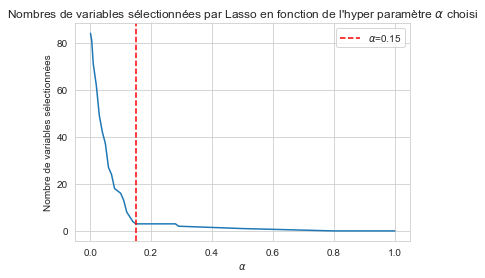

In [85]:
yindex = donnees_lasso.columns.get_loc("ref")
alphas = np.array([0.001,0.005]+[i/100 for i in range(1,30)]+[0.5,0.8,1.0])

alpha_for_path, coefs_lasso, _ = lasso_path(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex],alphas=alphas)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

sns.set_style("whitegrid")
sns.lineplot(y=nb_non_zero, x=alpha_for_path).set(title = r"Nombres de variables sélectionnées par Lasso en fonction de l'hyper paramètre $\alpha$ choisi", xlabel=r'$\alpha$', ylabel='Nombre de variables sélectionnées')
plt.axvline(0.15, 0,80,color="red",linestyle="--",label = r"$\alpha$=0.15")
plt.legend(loc='upper right')
plt.show()

$\hookrightarrow$ On remarque que le nombre de variables sélectionnées décroit très rapidement. On peut supposer que cela est du au fait que si on établit que le quartier n'a pas d'influence sur le loyer, on peut directement écarter 79 variables...

$\hookrightarrow$ Il y a un point d'inflexion sur la courbe précédente, pour la valeur d'hyper paramètre $\alpha = 0.15$. On choisit donc cette valeur pour réaliser notre sélection de variables. 

#### c) Modèle Lasso avec $\alpha = 0.15$

In [86]:
alpha = 0.15

lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
lasso1.fit(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex])

print("Coefficients estimés par modèle LASSO avec alpha = "+str(alpha)+":")
print(np.abs(lasso1.coef_))

print("Variables sélectionnées par modèle LASSO avec alpha = "+str(alpha)+":")
print(donnees_lasso.drop("ref", axis = 1).columns[np.abs(lasso1.coef_)>0])


Coefficients estimés par modèle LASSO avec alpha = 0.15:
[0.3980399  0.13119295 0.         0.         0.22604745 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
Variables sélectionnées par modèle LASSO avec alpha = 0.15:
Index(['piece', 'dista

$\hookrightarrow$ Le modèle LASSO avec $\alpha = 0.15$ sélectionne donc le nombre de pièces comme ayant la plus grande incidence sur le loyer. Il sélectionne également la distance au centre de Paris, qui est une information sur les quartiers et représentae une partie de la "demande", et le fait que le logement soit proposé comme meublé ou non.

Le fait que le nombre de pièces et le caractère meublé ou non d'un logement soient primordiales dans la détermination de son loyer n'est pas étonnant. Cela fait partie des premiers critères avec la localisation, qui est en partie prise en compte dans la distance au centre de Paris.

En revanche, on ne retrouve pas la superficie des quartiers, considérée comme liée à la "demande". On ne retrouve pas non plus le score du métro/rer que nous avons créé. Peut être qu'il n'a pas été réalisé avec assez de précision pour rendre bien compte des capacités de chaque quartier... 

Avec un $\alpha$ légèrement plus petit, on peut essayer de regarder qu'elles variables auraient pu être sélectionnées après ces trois variables principales :

In [88]:
alpha = 0.13

lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
lasso1.fit(np.delete(data_lasso, yindex, axis = 1),data_lasso[:,yindex])

print("Coefficients estimés par modèle LASSO : ")
print(np.abs(lasso1.coef_))

print("Colonnes sélectionnées par modèle LASSO : ")
print(donnees_lasso.drop("ref", axis = 1).columns[np.abs(lasso1.coef_)>0])

Coefficients estimés par modèle LASSO : 
[0.4180399  0.1511576  0.         0.         0.24604745 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00141474 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01943677 0.00945549 0.        ]
Colonnes sélectionnées par modèle LASSO : 
Index(['piece', 'distance_centre_paris', 'meuble_bin', 

$\hookrightarrow$ Si on diminue légèrement $\alpha$ pour prendre $\alpha=0.13$, on remarque que deux des variables correspondant à l'époque de construction et la variable indicatrice du quartier Gare (50) sont également sélectionnées, mais obtiennent des coefficients beaucoup plus petits. Cela est dur à interpréter. Le fait que l'époque entre en jeu témoigne peut être de l'état des logements, ce qui influence leur prix à la baisse lorsque les appartements sont en mauvais état (ce qui n'est pas rare à Paris...). 

# Partie 3 - Modélisation 

*(Les fonctions de cette partie sont disponibles dans les dossiers `modelisation` du dépôt git)*

$\Rightarrow$ **ici, mettre les différents modèles implémentés**